In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out and (origin != 13207 or dest != 13934):
        G.add_edge(id_[origin], id_[dest])
G.add_edge(id_[13207], id_[14104])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
get_size_weight(G, W, [0] * N, 744)

(4586, 110204.42095686687)

In [4]:
ids_orig = [13934, 14104, 13949, 15720, 13932, 13923, 14930, 131454, 15996, 15671, 13896, 14791, 15487]
ids = [13934, 14104, 13949, 15720, 13932, 13923, 14930, 16634, 15996, 15671, 15345, 14791, 15487]
tested_ids_orig = [id_[u] for u in ids_orig]
tested_ids = [id_[u] for u in ids]
tested_ids

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 240, 4201, 3876, 3553, 3002, 3692]

In [5]:
tested_ids_orig = set(tested_ids_orig)
sample_orig = []

V = [0] * N

Q = deque([744])
while Q and tested_ids_orig:
    
    u = Q.popleft()
    
    if u in tested_ids_orig:
        sample_orig.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample_orig)

tested_ids = set(tested_ids)
sample = []

V = [0] * N

Q = deque([744])
while Q and tested_ids:
    
    u = Q.popleft()
    
    if u in tested_ids:
        sample.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample)

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3002, 3692]
[2149, 2319, 2164, 3929, 2150, 2140, 3141, 240, 4201, 3876, 3002, 3553, 3692]


In [6]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    V_ = V.copy()
    for u in I:
        V_[u] = 1
    
    return V_, len(I)

In [7]:
WI = {}
V = [0] * N; VR = [0] * N
for u in sample[::-1]:
    s, w = get_size_weight(G, W, V, u)
    s, w_low = get_size_weight_robust(G, W, V, 744, u)
    s, w_high = get_size_weight(G, W, VR, u)
    WI[_id[u]] = w
    V, _ = visit(G, V, u)
    VR, _ = visit_robust(G, VR, 744, u)
    print(_id[u], ' ' * 4, round(w, 1), ' ' * 4, round(w_low, 1), ' ' * 4, round(w_high, 1), ' ' * 4, round(get_size_weight(G, W, [0] * N, u)[1], 1), ' ' * 4, round(get_size_weight_robust(G, W, [0] * N, 744, u)[1], 1))

15487      2276.7      548.4      2276.7      2276.7      548.4
15345      532.9      291.0      2261.3      2809.6      839.4
14791      6908.4      6908.4      6908.4      6908.4      6908.4
15671      5905.6      5692.0      5905.6      12813.9      12600.4
15996      10364.9      10253.2      10540.8      10540.8      10253.2
16634      13670.5      13158.2      15790.4      39659.1      39146.7
14930      4881.1      4665.7      5393.5      5393.5      4665.7
13923      3680.9      3680.9      3896.4      9074.4      8562.0
13932      8696.6      7428.6      8696.6      8696.6      7428.6
15720      13999.8      12752.6      13999.8      13999.8      12752.6
13949      8502.0      8502.0      9770.0      9770.0      8502.0
14104      23409.4      23409.4      24656.6      37409.3      37409.3
13934      7375.4      7375.4      7375.4      110204.4      110204.4


In [8]:
def plot_sample_no_intersections(G, V_, sample, geom, _id, name):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1
            
    newC = list(range(len(sample)))
    random.shuffle(newC)
    for u in range(N):
        if C[u] > 0:
            C[u] = newC[C[u] - 1] + 1
            
    newC_ = [0] * len(newC)
    for i in range(len(newC)):
        newC_[newC[i]] = i

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    
    for i in range(len(coord)):
        coord[i] = coord[i].buffer(100)
    
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i + 1] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [newC[i] + 1]

    label_ids = "   ".join([f"{i + 1}: {_id[sample[newC_[i]]]}" for i in range(len(sample))])
        
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': f"-1: No considerado   0: No cubierto   "+ label_ids, 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.savefig(f"{name}.pdf", dpi=1000)

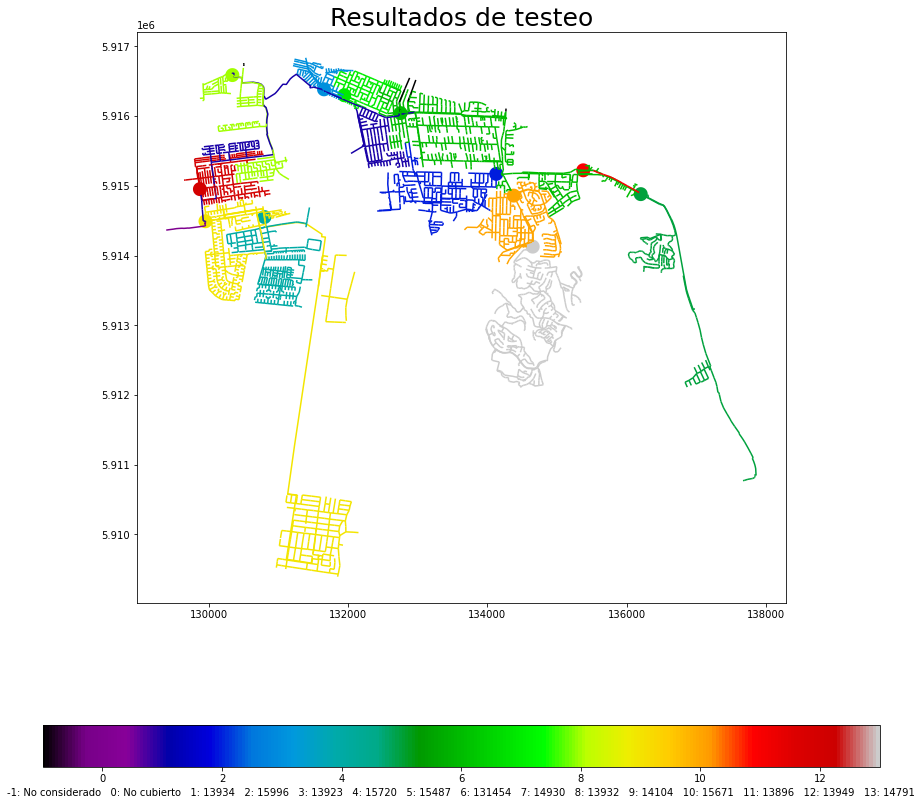

In [9]:
plot_sample_no_intersections(G, [0] * N, sample_orig[::-1] , geometry, _id, "map_orig")

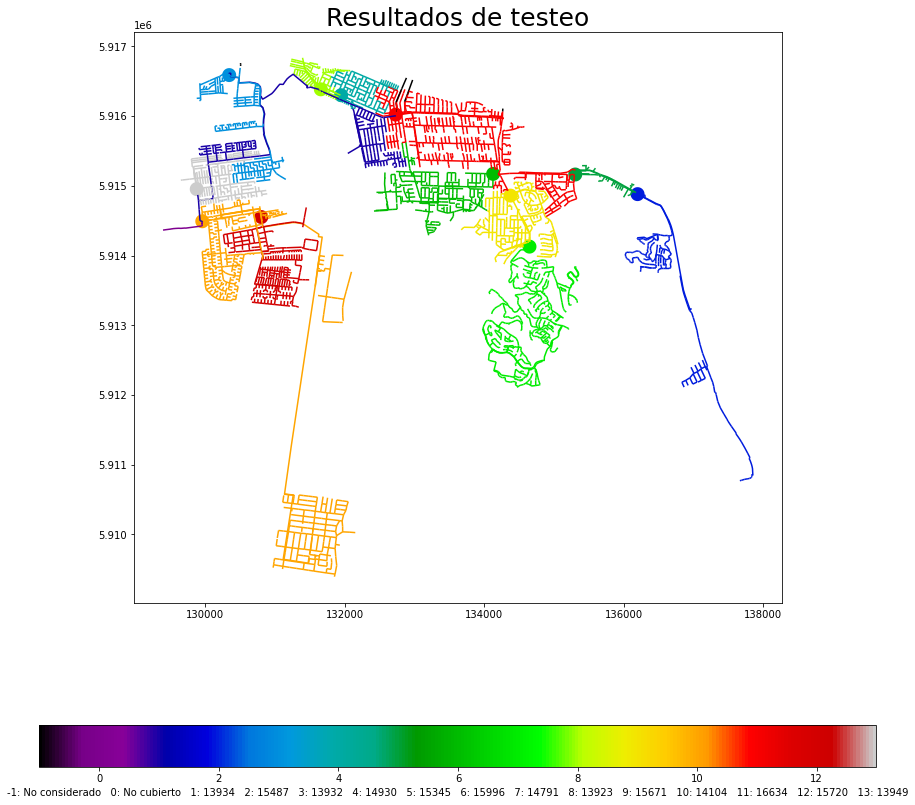

In [10]:
plot_sample_no_intersections(G, [0] * N, sample[::-1] , geometry, _id, "map_changes")

In [11]:
DG = nx.DiGraph()

ss = set(sample)

for r in sample:
    
    V = [0] * N
    
    Q = deque([r])
    while Q:
        
        u = Q.popleft()
        
        for v in G.predecessors(u):
            if not V[v] and v not in ss:
                Q.append(v)
                V[v] = 1
            if not V[v] and v in ss:
                DG.add_edge(_id[r], _id[v])
                V, _ = visit(G, V, v)

In [12]:
print(DG.edges())

[(13934, 14104), (13934, 13949), (13934, 13932), (13934, 13923), (13934, 16634), (14104, 15720), (13923, 14930), (16634, 15996), (16634, 15671), (16634, 15345), (15671, 14791), (15345, 15487)]


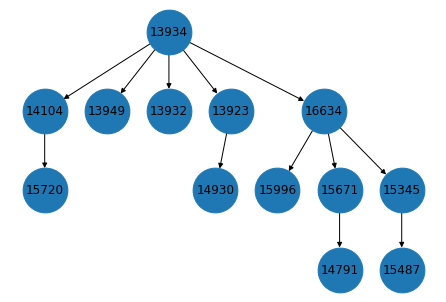

In [13]:
pos = graphviz_layout(DG, prog="dot")
nx.draw(DG, pos, with_labels=True, node_size=2000)
plt.savefig("tree")

In [14]:
def equal_structure(G, s1, s2):
    
    if len(s1) != len(s2):
        return False
    
    n = len(s1)
    
    
    ans = True
    for i in range(n):
        for j in range(n):
            if i != j:
                if ((s1[j] in get_ideal(G, [0] * N, s1[i])) and not (s2[j] in get_ideal(G, [0] * N, s2[i]))):
#                     print(f"{_id[s1[j]]} in {_id[s1[i]]}   but   {_id[s2[j]]} not in {_id[s2[i]]}")
                    ans = False
                if (not (s1[j] in get_ideal(G, [0] * N, s1[i])) and (s2[j] in get_ideal(G, [0] * N, s2[i]))):
#                     print(f"{_id[s1[j]]} not in {_id[s1[i]]}   but   {_id[s2[j]]} in {_id[s2[i]]}")
                    ans = False
    
    return ans

In [19]:
def equal_structure_robust(G, s1, s2):
    
    if len(s1) != len(s2):
        return False
    
    n = len(s1)
    
    
    ans = True
    for i in range(n):
        for j in range(n):
            if i != j:
                if ((s1[j] in get_ideal_robust(G, [0] * N, 744, s1[i])) and not (s2[j] in get_ideal_robust(G, [0] * N, 744, s2[i]))):
#                     print(f"{_id[s1[j]]} in {_id[s1[i]]}   but   {_id[s2[j]]} not in {_id[s2[i]]}")
                    ans = False
                if (not (s1[j] in get_ideal_robust(G, [0] * N, 744, s1[i])) and (s2[j] in get_ideal_robust(G, [0] * N, 744, s2[i]))):
#                     print(f"{_id[s1[j]]} not in {_id[s1[i]]}   but   {_id[s2[j]]} in {_id[s2[i]]}")
                    ans = False
    
    return ans

In [20]:
equal_structure(G, sample, sample_orig)

False

In [21]:
Alts = {
    13934: [13209, 13208, 13207],
    14104: [13207, 13208, 13209],
    13949: [13951, 13952, 13933],
    15720: [15452, 141747, 15451],
    13932: [13936, 1003333, 1003204],
    13923: [1003182, 117840, 13926],
    14930: [15332, 14561, 14930],
    16634: [13613, 13612, 13611],
    15996: [13853, 13854, 13856],
    15671: [15095, 15097, 15093],
    15098: [13853, 13854, 13856],
    14791: [13494, 13496, 13493],
    15487: [15488, 15489, 14324]
}

In [22]:
sample = [id_[u] for u in Alts.keys()]

In [23]:
for k in Alts.keys():
    print(f"Alternatives for {k}: ", end=" ")
    for v in Alts[k]:
        sample_ = sample.copy()
        for i in range(len(sample_)):
            if sample_[i] == id_[k]:
                sample_[i] = id_[v]
        print(equal_structure(G, sample, sample_), end=" ")
    print()

Alternatives for 13934:  False False False 
Alternatives for 14104:  True True True 
Alternatives for 13949:  False False False 
Alternatives for 15720:  True True True 
Alternatives for 13932:  False False False 
Alternatives for 13923:  False False False 
Alternatives for 14930:  True True True 
Alternatives for 16634:  True True True 
Alternatives for 15996:  False False False 
Alternatives for 15671:  False True True 
Alternatives for 15098:  False False False 
Alternatives for 14791:  True True True 
Alternatives for 15487:  True True True 


In [24]:
for k in Alts.keys():
    print(f"Alternatives for {k}: ", end=" ")
    for v in Alts[k]:
        sample_ = sample.copy()
        for i in range(len(sample_)):
            if sample_[i] == id_[k]:
                sample_[i] = id_[v]
        print(equal_structure_robust(G, sample, sample_), end=" ")
    print()

Alternatives for 13934:  False False False 
Alternatives for 14104:  True True True 
Alternatives for 13949:  False False False 
Alternatives for 15720:  True True True 
Alternatives for 13932:  False False False 
Alternatives for 13923:  False False False 
Alternatives for 14930:  True True True 
Alternatives for 16634:  True True True 
Alternatives for 15996:  False False False 
Alternatives for 15671:  False True True 
Alternatives for 15098:  False False False 
Alternatives for 14791:  True True True 
Alternatives for 15487:  True True True 
